In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

from time import time
from operator import itemgetter

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

SELECT_YEAR = 2017

DATA_PATH = './data'
PLOT_PATH = './docs/plots/{}'.format(SELECT_YEAR)


In [2]:
# Data Read
data_file = '{}/{}_lattes.pkl.xz'.format(DATA_PATH, SELECT_YEAR)
%time df = pd.read_pickle(data_file, compression='xz')
print('{} docs shape'.format(df.shape))
df.head(10)

CPU times: user 238 ms, sys: 18.8 ms, total: 257 ms
Wall time: 270 ms
(8652, 4) docs shape


,id,titulo,clean,w_count
0,104124422364023,Exploiting photo location and direction for cl...,"[exploit, photo, locat, direct, cluster, base,...",9
1,104124422364023,A gold-standard social media corpus for urban ...,"[gold, standard, social, media, corpus, urban,...",8
2,104124422364023,A Framework for Spatial Analytics using Hetero...,"[framework, spatial, analyt, use, heterogen, d...",9
3,105670521813027,Gene expression analysis in Musa acuminata dur...,"[gene, express, analysi, musa, acuminata, comp...",12
4,105670521813027,Mitogenome sequence accuracy using different e...,"[mitogenom, sequenc, accuraci, use, differ, el...",7
5,109837868064895,A study of equivalent electrical circuit fitti...,"[studi, equival, electr, circuit, fit, electro...",14
6,116792663386170,DYNAMICS OF CONNECTED VESSELS WITH RUNAWAY REA...,"[dynam, connect, vessel, runaway, reaction, ri...",14
7,116792663386170,VLE BASED DYNAMIC SIMULATION OF A TRICKLE-BED ...,"[vle, base, dynam, simul, trickl, bed, reactor...",13
8,116792663386170,SOLUBILITY BEHAVIOR OF GAMMA-VALEROLACTONE + N...,"[solubl, behavior, gamma, valerolacton, tetrad...",9
9,116792663386170,Removal of amoxicillin from water by adsorptio...,"[remov, amoxicillin, water, adsorpt, onto, act...",25


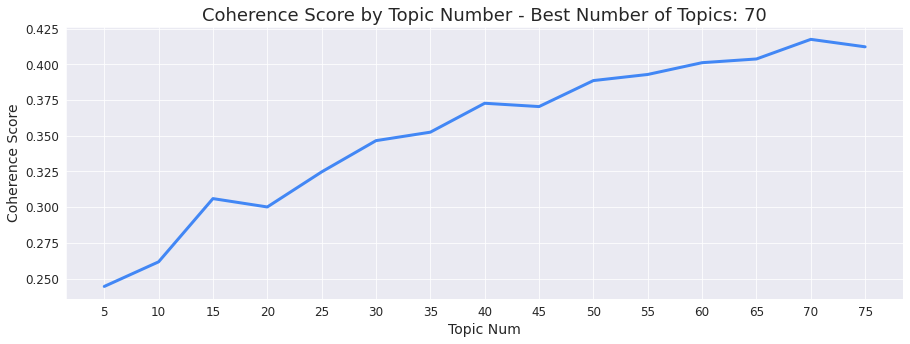

Time: 5.18 mins


In [3]:
# Use Gensim's NMF to get the best num of topics via coherence score

def graph_coherence(texts):
    # Create a dictionary
    # In gensim a dictionary is a mapping between words and their integer id
    dictionary = Dictionary(texts)

    # Filter out extremes to limit the number of features
    dictionary.filter_extremes(
        no_below=3,
        no_above=0.85,
        keep_n=5000
    )

    # Create the bag-of-words format (list of (token_id, token_count))
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Create a list of the topic numbers we want to try
    topic_nums = list(np.arange(5, 75 + 1, 5))

    # Run the nmf model and calculate the coherence score
    # for each number of topics
    coherence_scores = []

    for num in topic_nums:
        nmf = Nmf(
            corpus=corpus,
            num_topics=num,
            id2word=dictionary,
            chunksize=2000,
            passes=5,
            kappa=.1,
            minimum_probability=0.01,
            w_max_iter=300,
            w_stop_condition=0.0001,
            h_max_iter=100,
            h_stop_condition=0.001,
            eval_every=10,
            normalize=True,
            random_state=42
        )
        
        # Run the coherence model to get the score
        cm = CoherenceModel(
            model=nmf,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        
        coherence_scores.append(round(cm.get_coherence(), 5))

    # Get the number of topics with the highest coherence score
    scores = list(zip(topic_nums, coherence_scores))
    best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

    # Plot the results
    fig = plt.figure(figsize=(15, 5))

    plt.plot(
        topic_nums,
        coherence_scores,
        linewidth=3,
        color='#4287f5'
    )

    plt.xlabel("Topic Num", fontsize=14)
    plt.ylabel("Coherence Score", fontsize=14)
    plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
    plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
    plt.yticks(fontsize=12)

    file_name = '/{}_c_score'.format(SELECT_YEAR)

    fig.savefig(
        PLOT_PATH + file_name + '.png',
        dpi=fig.dpi,
        bbox_inches='tight'
    )

    plt.show()
    return best_num_topics

t = time()
texts = df['clean']
best_num_topics = graph_coherence(texts)
print('Time: {} mins'.format(round((time() - t) / 60, 2)))

In [4]:
best_num_topics = 20

In [5]:
# Create the tfidf
texts = df['clean']

tfidf_vectorizer = TfidfVectorizer(
    min_df=0.0005,
    max_df=0.1,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)
tfidf_fn = tfidf_vectorizer.get_feature_names()

print('vocabulary: {}'.format(len(tfidf_vectorizer.vocabulary_)))
print('sparse matrix shape: {}'.format(tfidf.shape))
print('nonzero count: {}'.format(tfidf.nnz))
print('sparsity: {:.3f}'.format(100.0 * tfidf.nnz / (tfidf.shape[0] * tfidf.shape[1])))

weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tfidf_vectorizer.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)



vocabulary: 3560
sparse matrix shape: (8652, 3560)
nonzero count: 74292
sparsity: 0.241


,term,weight
1991,model,0.017957
3123,system,0.016755
2107,network,0.016096
130,analysi,0.015714
792,data,0.013562
178,approach,0.012278
1725,learn,0.011064
3056,studi,0.010943
101,algorithm,0.010550
2925,softwar,0.010229


In [6]:
# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

def list_topics(model, feature_names, no_top_words):
    idx2word = np.array(feature_names)
    for i, topic in enumerate(model.components_):
        print('{:02d}: {}'.format(
            i + 1, ','.join([x for x in idx2word[topic.argsort()[:-no_top_words - 1:-1]]])))

list_topics(nmf,tfidf_fn,8)

01: algorithm,problem,genet,genet algorithm,schedul,parallel,heurist,rout
02: network,neural,neural network,convolut,convolut neural,classif,artifici,artifici neural
03: softwar,develop,softwar develop,engin,softwar engin,project,educ,ecosystem
04: model,simul,model base,base model,framework,ontolog,driven,predict
05: data,mine,data mine,stream,data stream,big,big data,visual
06: system,control,inform,distribut,architectur,system base,inform system,embed
07: learn,machin,environ,machin learn,learn environ,educ,deep,reinforc learn
08: analysi,visual,compar,social,brazilian,network analysi,social network,gene
09: studi,case,case studi,brazilian,brazil,studi brazilian,exploratori,code
10: detect,imag,method,automat,segment,featur,recognit,classif
11: systemat,review,literatur,literatur review,map,systemat literatur,systemat map,systemat review
12: evalu,perform,perform evalu,improv,evalu use,tool,strategi,automat
13: sensor,wireless,sensor network,wireless sensor,network,power,industri,ad

In [7]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["T%d_words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["T%d_wgt" % (topic_idx)]= ['{:.3f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

display_topics(nmf,tfidf_fn,10)


,T0_words,T0_wgt,T1_words,T1_wgt,T2_words,T2_wgt,T3_words,T3_wgt,T4_words,T4_wgt,...,T15_words,T15_wgt,T16_words,T16_wgt,T17_words,T17_wgt,T18_words,T18_wgt,T19_words,T19_wgt
0,algorithm,6.892,network,1.881,softwar,2.002,model,2.155,data,2.189,...,applic,1.863,comput,1.696,product,1.597,process,1.943,optim,1.682
1,problem,5.610,neural,1.250,develop,1.275,simul,0.247,mine,0.375,...,mobil,1.093,cloud,0.925,line,0.804,busi,0.430,multi,1.013
2,genet,2.852,neural network,1.198,softwar develop,0.690,model base,0.228,data mine,0.357,...,design,0.466,internet,0.613,product line,0.717,busi process,0.353,object,0.809
3,genet algorithm,2.486,convolut,0.548,engin,0.585,base model,0.160,stream,0.323,...,mobil applic,0.304,thing,0.592,softwar product,0.574,graph,0.299,multi object,0.504
4,schedul,1.228,convolut neural,0.525,softwar engin,0.393,framework,0.147,data stream,0.288,...,cost,0.200,internet thing,0.560,architectur,0.312,process model,0.227,swarm,0.273
5,parallel,1.181,classif,0.315,project,0.382,ontolog,0.139,big,0.235,...,devic,0.199,environ,0.559,measur,0.277,mine,0.180,particl,0.271
6,heurist,1.161,artifici,0.293,educ,0.252,driven,0.137,big data,0.207,...,mobil devic,0.161,cloud comput,0.555,collis,0.243,process mine,0.171,object optim,0.269
7,rout,1.103,artifici neural,0.282,ecosystem,0.248,predict,0.131,visual,0.189,...,applic use,0.154,secur,0.382,line architectur,0.241,support,0.168,particl swarm,0.256
8,hybrid,0.980,social,0.230,test,0.235,estim,0.108,framework,0.179,...,toward,0.149,servic,0.342,atlas,0.210,inform,0.139,swarm optim,0.255
9,search,0.898,deep,0.195,softwar ecosystem,0.218,model driven,0.105,open,0.168,...,interfac,0.137,virtual,0.243,softwar,0.207,manag,0.138,agent,0.174


In [8]:
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8
topic_df = topic_table(nmf, tfidf_fn, n_top_words).T

topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(word_tokenize) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()


,0,1,2,3,4,5,6,7,topics
0,algorithm,problem,genet,genet algorithm,schedul,parallel,heurist,rout,algorithm problem genet schedul parallel heuri...
1,network,neural,neural network,convolut,convolut neural,classif,artifici,artifici neural,network neural convolut classif artifici
2,softwar,develop,softwar develop,engin,softwar engin,project,educ,ecosystem,softwar develop engin project educ ecosystem
3,model,simul,model base,base model,framework,ontolog,driven,predict,model simul base framework ontolog driven predict
4,data,mine,data mine,stream,data stream,big,big data,visual,data mine stream big visual


In [9]:
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df.head(10)

,topic_num,topics
0,0,algorithm problem genet schedul parallel heuri...
1,1,network neural convolut classif artifici
2,2,softwar develop engin project educ ecosystem
3,3,model simul base framework ontolog driven predict
4,4,data mine stream big visual
5,5,system control inform distribut architectur ba...
6,6,learn machin environ educ deep reinforc
7,7,analysi visual compar social brazilian network...
8,8,studi case brazilian brazil exploratori code
9,9,detect imag method automat segment featur reco...


In [10]:
df_temp = pd.DataFrame({
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df,
    merged_topic,
    left_index=True,
    right_index=True
)

df_topics = df_topics.drop(['w_count','clean'],axis=1)
df_topics.head(10)


,id,titulo,topic_num,topics
0,104124422364023,Exploiting photo location and direction for cl...,9,detect imag method automat segment featur reco...
1,104124422364023,A gold-standard social media corpus for urban ...,1,network neural convolut classif artifici
2,104124422364023,A Framework for Spatial Analytics using Hetero...,4,data mine stream big visual
3,105670521813027,Gene expression analysis in Musa acuminata dur...,7,analysi visual compar social brazilian network...
4,105670521813027,Mitogenome sequence accuracy using different e...,9,detect imag method automat segment featur reco...
5,109837868064895,A study of equivalent electrical circuit fitti...,8,studi case brazilian brazil exploratori code
6,116792663386170,DYNAMICS OF CONNECTED VESSELS WITH RUNAWAY REA...,11,evalu perform improv use tool strategi automat
7,116792663386170,VLE BASED DYNAMIC SIMULATION OF A TRICKLE-BED ...,3,model simul base framework ontolog driven predict
8,116792663386170,SOLUBILITY BEHAVIOR OF GAMMA-VALEROLACTONE + N...,7,analysi visual compar social brazilian network...
9,116792663386170,Removal of amoxicillin from water by adsorptio...,18,process busi graph model mine support


In [11]:
# Showing the 3 matrices we get witn nmf
A = tfidf_vectorizer.transform(texts)
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

A = 8652 x 3560
W = 20 x 3560
H = 8652 x 20


In [12]:
# Get the residuals for each document
r = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')

sum_sqrt_res = round(sum(np.sqrt(r)), 3)
'Sum of the squared residuals is {}'.format(sum_sqrt_res)

'Sum of the squared residuals is 8467.805'

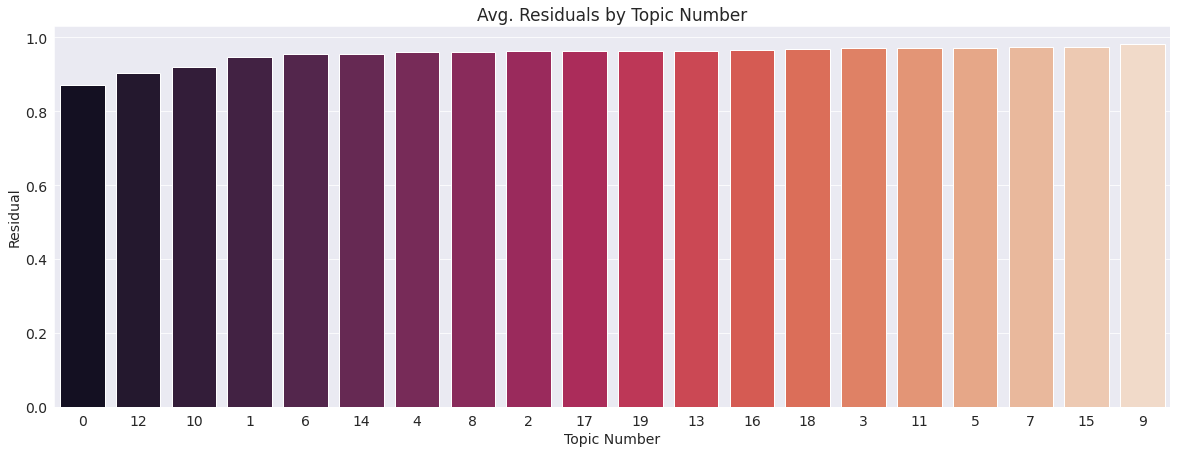

In [13]:
# Add the residuals to the df
df_topics['resid'] = r

# Get the avg residual by topic
resid_data = df_topics[[
    'topic_num',
    'resid'
]].groupby('topic_num').mean().sort_values(by='resid')

# Plot a bar chart for the avg. residuls by topic
fig = plt.figure(figsize=(20,7))

x = resid_data.index
y = resid_data['resid']
    
g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='rocket'
)

g.set_xticklabels(
    g.get_xticklabels(),
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Topic Number', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title('Avg. Residuals by Topic Number', fontsize=17)

file_name = '/{}_avg_resid'.format(SELECT_YEAR)

fig.savefig(
    PLOT_PATH + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

<Figure size 1080x360 with 0 Axes>

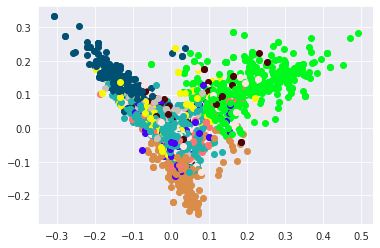

Time: 5.27 mins


In [17]:
# Create k-means model with custom config

def graph_KMeans(tfidf):
    num_clusters = 10
    num_seeds = 10
    max_iterations = 300
    labels_color_map = {
        0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
        5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
    }
    pca_num_components = 2

    clustering_model = KMeans(
        n_clusters=num_clusters,
        max_iter=max_iterations,
        precompute_distances="auto",
        n_jobs=-1
    )

    labels = clustering_model.fit_predict(tfidf)

    X = tfidf.todense()

    reduced_data = PCA(n_components=pca_num_components).fit_transform(X)

    fig = plt.figure(figsize=(15, 5))

    fig, ax = plt.subplots()
    for index, instance in enumerate(reduced_data):
        pca_comp_1, pca_comp_2 = reduced_data[index]
        color = labels_color_map[labels[index]]
        ax.scatter(pca_comp_1, pca_comp_2, c=color)

    file_name = '/{}_KMeans'.format(SELECT_YEAR)

    fig.savefig(
        PLOT_PATH + file_name + '.png',
        dpi=fig.dpi,
        bbox_inches='tight'
    )

    plt.show()

t = time()
graph_KMeans(tfidf)
print('Time: {} mins'.format(round((time() - t) / 60, 2)))

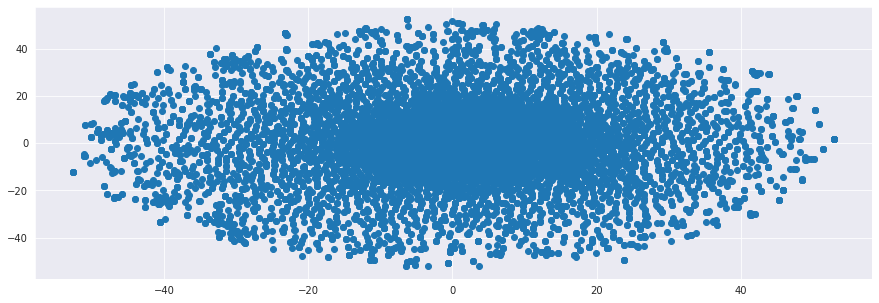

Time: 12.64 mins


In [18]:
# t-SNE plot

def graph_tsne(tfidf):
    X = tfidf.todense()
    tsne_num_components = 2
    embeddings = TSNE(n_components=tsne_num_components)
    Y = embeddings.fit_transform(X)

    fig = plt.figure(figsize=(15, 5))

    plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)

    file_name = '/{}_tsne'.format(SELECT_YEAR)

    fig.savefig(
        PLOT_PATH + file_name + '.png',
        dpi=fig.dpi,
        bbox_inches='tight'
    )

    plt.show()

t = time()
graph_tsne(tfidf)
print('Time: {} mins'.format(round((time() - t) / 60, 2)))


In [16]:
# Save
path = '{}/'.format(DATA_PATH)

topics_file = '{}/{}_topics.pkl.xz'.format(DATA_PATH, SELECT_YEAR)
%time df_topics.to_pickle(topics_file, compression='xz')

CPU times: user 728 ms, sys: 26 ms, total: 754 ms
Wall time: 761 ms
